In [2]:
!pip install medmnist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 2.8 MB/s eta 0:00:00


In [3]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [ ]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.0 @ https://github.com/MedMNIST/MedMNIST/


# We first work on a 2D dataset with size 28x28

In [4]:
data_flag = 'pathmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 8
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [5]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

100%|██████████| 206M/206M [00:28<00:00, 7.14MB/s]


In [ ]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PathMNIST of size 28 (pathmnist)
    Number of datapoints: 89996
    Root location: /home/sr/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-1

In [6]:
# visualization

train_dataset.montage(length=1)

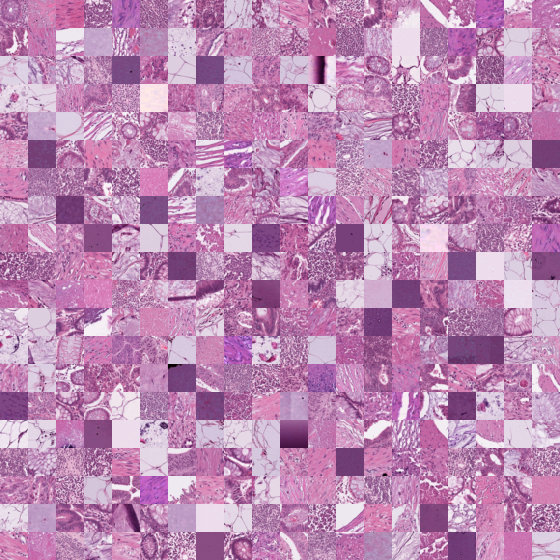

In [7]:
# montage

train_dataset.montage(length=20)

## Then, we define a simple model for illustration, object function and optimizer that we use to classify.

In [8]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

## Next, we can start to train and evaluate!

In [9]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0

    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

100%|██████████| 11250/11250 [04:25<00:00, 42.39it/s]


In [11]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))


print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.994  acc:0.915
test  auc: 0.973  acc:0.827


# We then check a 2D dataset with size 224x224

In [ ]:
data_flag = 'pathmnist'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download, size=224, mmap_mode='r')

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

Using downloaded and verified file: /home/sr/.medmnist/pathmnist_224.npz


In [ ]:
x, y = train_dataset[0]

print(x.shape, y.shape)

torch.Size([3, 224, 224]) (1,)


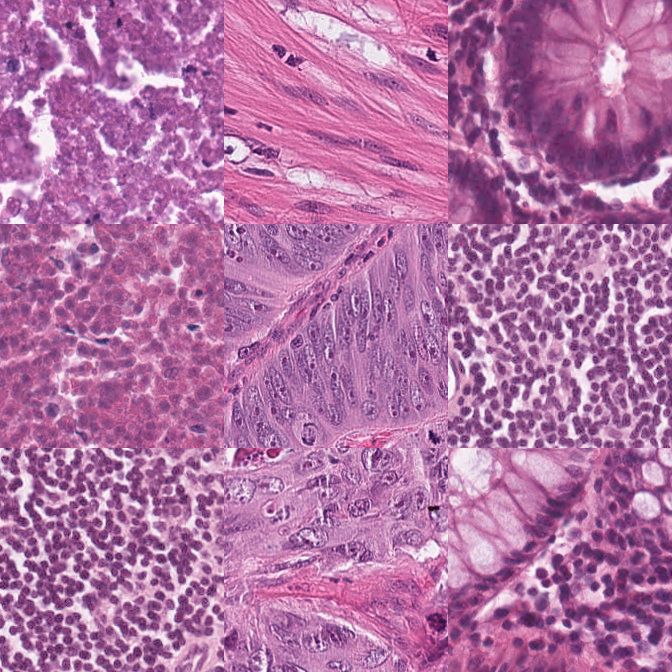

In [ ]:
train_dataset.montage(length=3)

## Then we train and evaluate on this 224x224 dataset

In [ ]:
from torchvision.models import resnet18

model = resnet18(num_classes=n_classes).cuda()

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [ ]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0

    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs.cuda())
        targets = targets.cuda()

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

100%|██████████| 704/704 [02:39<00:00,  4.41it/s]


In [10]:
split = 'test'

model.eval()
y_true = torch.tensor([])
y_score = torch.tensor([])

data_loader = train_loader_at_eval if split == 'train' else test_loader

with torch.no_grad():
    for inputs, targets in data_loader:
        inputs = inputs.cuda()
        outputs = model(inputs)
        outputs = outputs.softmax(dim=-1)
        y_score = torch.cat((y_score, outputs.cpu()), 0)

    y_score = y_score.detach().numpy()

    evaluator = Evaluator(data_flag, split, size=224)
    metrics = evaluator.evaluate(y_score)

    print('%s  auc: %.3f  acc: %.3f' % (split, *metrics))

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

# We then check a 3D dataset with size 28x28x28

In [ ]:
data_flag = 'organmnist3d'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

Using downloaded and verified file: /home/sr/.medmnist/organmnist3d.npz


In [ ]:
x, y = train_dataset[0]

print(x.shape, y.shape)

(1, 28, 28, 28) (1,)


In [ ]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 1, 28, 28, 28]) torch.Size([128, 1])


In [ ]:
frames = train_dataset.montage(length=1, save_folder="tmp/")
frames[10]

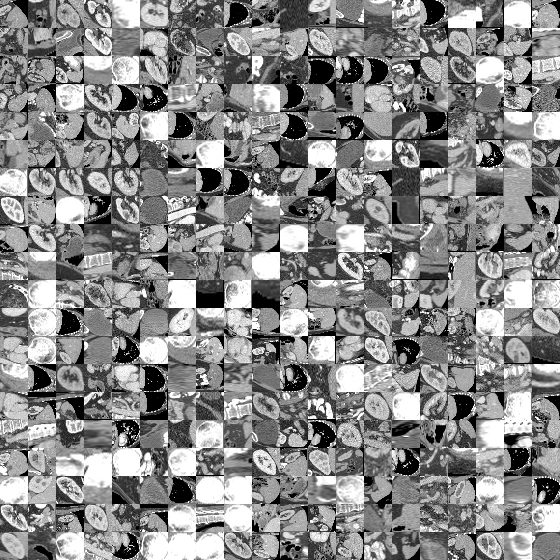

In [ ]:
frames = train_dataset.montage(length=20, save_folder="tmp/")

frames[10]

## Go and check the generated [gif](tmp/organmnist3d_train_montage.gif) ;)

# We then check a 3D dataset with size 64x64x64

In [ ]:
data_flag = 'organmnist3d'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download, size=64)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

Using downloaded and verified file: /home/sr/.medmnist/organmnist3d_64.npz


In [ ]:
x, y = train_dataset[0]

print(x.shape, y.shape)

(1, 64, 64, 64) (1,)


In [ ]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 1, 64, 64, 64]) torch.Size([128, 1])


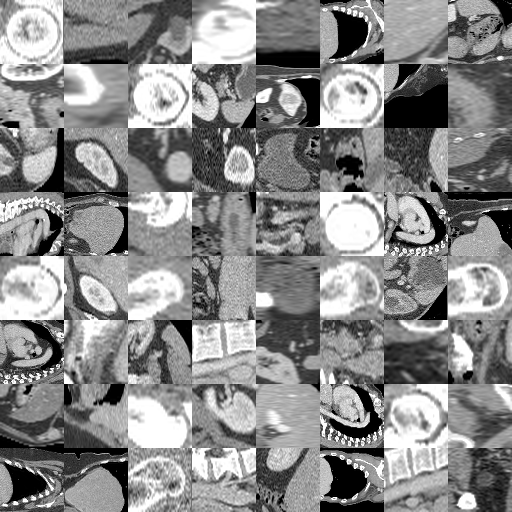

In [ ]:
frames = train_dataset.montage(length=8, save_folder="tmp/")

frames[10]

## Go and check the generated [gif](tmp/organmnist3d_64_train_montage.gif) ;)

# Check [EXTERNAL] [`MedMNIST/experiments`](https://github.com/MedMNIST/experiments)

Training and evaluation scripts to reproduce both 2D and 3D experiments in our paper, including PyTorch, auto-sklearn, AutoKeras and Google AutoML Vision together with their weights ;)

In [1]:
torch.save(model.state_dict(), "my_medmnist_model.pth")


Testing Medical AI...

🧠 BASIC MEDICAL AI DIAGNOSIS
Patient Data: Chest pain, cough
🤒 Diagnosis: Cancer
📈 Confidence: 76%
🚨 Status: Urgent care recommended

🧠 BASIC MEDICAL AI DIAGNOSIS
Patient Data: Normal checkup
🤒 Diagnosis: COVID-19
📈 Confidence: 73%
🚨 Status: Urgent care recommended


In [ ]:
import torch
from torch import nn

# Recreate the same network architecture
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1  = nn.Linear(64 * (28//4) * (28//4), 128)
        self.fc2  = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

model = SimpleCNN(in_channels=3, num_classes=9)  # adjust to dataset
model.load_state_dict(torch.load("my_medmnist_model.pth", map_location="cpu"))
model.eval()


In [ ]:
from PIL import Image
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor(),
])

img = Image.open("sample.png").convert("RGB")
x = transform(img).unsqueeze(0)  # add batch dimension


In [ ]:
with torch.no_grad():
    logits = model(x)
    predicted_class = torch.argmax(logits, dim=1).item()
print("Predicted class:", predicted_class)


In [ ]:
from medmnist import INFO
info = INFO['pathmnist']
label_names = info['label']
print("Predicted label:", label_names[str(predicted_class)])


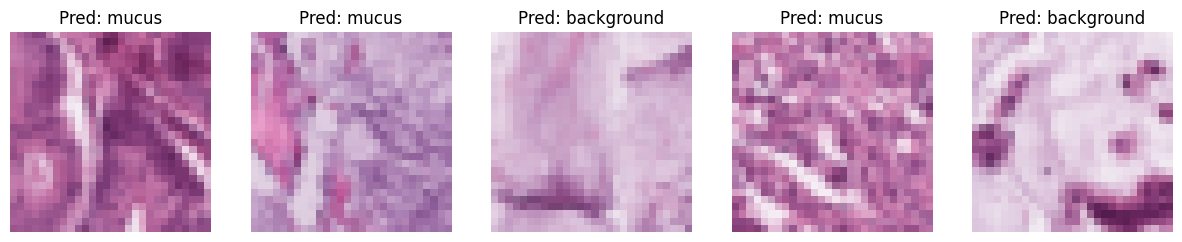

In [13]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from medmnist import PathMNIST, INFO
import matplotlib.pyplot as plt

# --- add a transform to convert PIL -> tensor ---
transform = transforms.ToTensor()

dataset_name = 'pathmnist'
info = INFO[dataset_name]
label_map = info['label']  # {'0':'class0', ...}

test_ds = PathMNIST(split='test', download=True, transform=transform)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

model.eval()

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
with torch.no_grad():
    for i, (img, _) in enumerate(test_loader):
        if i >= 5:
            break
        pred_idx = model(img).argmax(dim=1).item()
        # img is [1,C,H,W]; remove batch and permute to HWC for plotting
        axes[i].imshow(img[0].permute(1, 2, 0))
        axes[i].axis('off')
        axes[i].set_title(f"Pred: {label_map[str(pred_idx)]}")
plt.show()
